In [3]:
# Supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
import numpy as np

In [5]:
df = pd.read_csv('reddit_posts_2022_04_12-03_12_51_PM_clean.csv', index_col=0)
preprocessed_reddit_posts = df['clean_selftext_unstemmed_without_numbers'].to_list()
preprocessed_reddit_titles = df[df['clean_title_unstemmed_without_numbers'].isna()==False]['clean_title_unstemmed_with_numbers'].to_list()

In [6]:
from nltk import TweetTokenizer

tt = TweetTokenizer()
tokenized_posts = [tt.tokenize(post) for post in preprocessed_reddit_posts]
tokenized_titles = [tt.tokenize(title) for title in preprocessed_reddit_titles]
tokenized_posts_flat = [word for post in tokenized_posts for word in post]
tokenized_titles_flat = [word for title in tokenized_titles for word in title]

In [7]:
used_stop_words_for_titles = ['covid', 'long', 'longcovid', 'haul', 'hauler', 'longhauler', 'longhaul', 'longhaulcovid', 'longhauling', 'long-haul', 'lc', 'lh', 'anyone', 'symptom', 'help', 'please', 'nineteen', 'question', 'else', 'post', 'hauler', 'test', 'issue', 'feel', 'like']
used_stop_words_for_posts = ['covid', 'long', 'longcovid', 'haul', 'hauler', 'longhauler', 'longhaul', 'longhaulcovid', 'longhauling', 'long-haul', 'lc', 'lh', 'like', 'symptom', 'feel', 'day', 'month', 'time', 'week', 'anyone', 'else', 'back', 'test', 'start', 'know', 'would', 'help', 'still', 'think', 'since', 'experience', 'try', 'make', 'really', 'could', 'issue', 'say', 'want', 'last', 'much', 'normal', 'felt', 'first', 'year', 'post', 'post', 'lot', 'anything', 'tell', 'life', 'well', 'around', 'use', 'positive', 'ago',  'sick', 'give', 'need', 'right', 'many', 'may', 'hour', 'able', 'feeling', 'notice', 'end', 'pretty', 'everything', 'read', 'problem', 'wonder', 'etc', 'point', 'everyone', 'people', 'similar', 'cause', 'negative', 'weird', 'though', 'later', 'next', 'case', 'past', 'march', 'virus', 'couple', 'hi', 'hello', 'hey', 'please', 'someone', 'thanks', 'however', 'story', 'others', 'already', 'finally', 'mostly', 'let', 'call', 'probably', 'quesion', 'thank', 'thanks', 'yet', 'include', 'december', 'begin', 'stuff']
used_stop_words = list(set(used_stop_words_for_titles + used_stop_words_for_posts))

In [8]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(used_stop_words)
def remove_stopwords(text, stop_words):
    return " ".join([word for word in text if word not in stop_words])

posts_without_stop_words = [remove_stopwords(post, used_stop_words_for_posts) for post in tokenized_posts]
titles_without_stop_words = [remove_stopwords(title, used_stop_words_for_titles) for title in tokenized_titles]

In [9]:
#defining a posts df
posts_df = pd.DataFrame(posts_without_stop_words)
posts_df.drop(posts_df[posts_df[0] == ''].index, inplace=True)
posts_df.rename(columns={0: "text"}, errors="raise", inplace=True)

#defining posts weights
posts_weights = np.empty(len(posts_df['text']))
posts_weights.fill(0.75)

#assigning weights to the posts
posts_df['weight'] = posts_weights
posts_df

text  weight
0                                    foods best tolerate    0.75
1      currently 7.5 voyage breathe briefly deal tach...    0.75
2      suggest always recover better mean better wors...    0.75
3      context late july mild fatigue pem change dail...    0.75
4      sub pretend anywhere near worse fatigue peak i...    0.75
...                                                  ...     ...
20585  topic picky eater convo today realize possibly...    0.75
20586  old february slowly develop wife blood clot ca...    0.75
20587                   place member longhaulerkids chat    0.75
20588  family partner kid caught bit brutal dad kid f...    0.75
20589                       place member covidlonga chat    0.75

[20495 rows x 2 columns]

In [10]:
#defining a titles df
titles_df = pd.DataFrame(titles_without_stop_words)
titles_df.drop(titles_df[titles_df[0] == ''].index, inplace=True)
titles_df.rename(columns={0: "text"}, errors="raise", inplace=True)

#defining posts weights
titles_weights = np.empty(len(titles_df['text']))
titles_weights.fill(1)

#assigning weights to the titles
titles_df['weight'] = titles_weights
titles_df

text  weight
0                             safe food     1.0
1                         much exercise     1.0
2                improve quite lot stop     1.0
3      lose 18lbs due start gain weight     1.0
4          debilitate still suck relate     1.0
...                                 ...     ...
20532                   dysgeusia child     1.0
20533                      child suffer     1.0
20534             longhaulerkids lounge     1.0
20535                     vaccinate kid     1.0
20536                 covidlonga lounge     1.0

[20272 rows x 2 columns]

In [11]:
text_df = pd.concat([posts_df, titles_df], axis=0)
text_df

text  weight
0                                    foods best tolerate    0.75
1      currently 7.5 voyage breathe briefly deal tach...    0.75
2      suggest always recover better mean better wors...    0.75
3      context late july mild fatigue pem change dail...    0.75
4      sub pretend anywhere near worse fatigue peak i...    0.75
...                                                  ...     ...
20532                                    dysgeusia child    1.00
20533                                       child suffer    1.00
20534                              longhaulerkids lounge    1.00
20535                                      vaccinate kid    1.00
20536                                  covidlonga lounge    1.00

[40767 rows x 2 columns]

## Clustering with weighted k-means

In [12]:
import sys

sys.path.append("../utils/clustering")

In [23]:
from kmeans import plot_elbow
from kmeans import mbkmeans_clusters

from clustering_viz import tsne_viz
from clustering_viz import create_wordcloud

#### TF-IDF + KMEANS

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(text_df['text'])

In [14]:
X.shape

(40767, 9275)

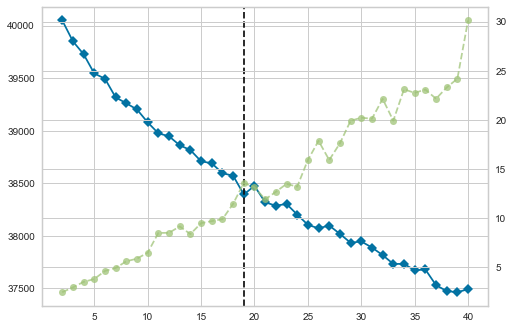

In [15]:
from kmeans import plot_elbow
from kmeans import mbkmeans_clusters

plot_elbow(X, y=text_df['weight'].to_list(), k_range=(2, 41))

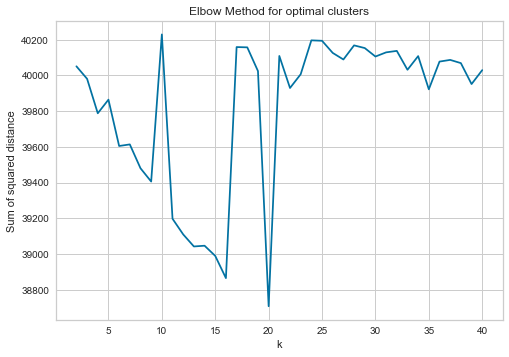

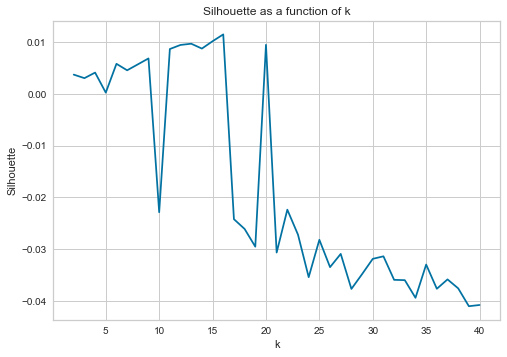

(MiniBatchKMeans(batch_size=1000, n_clusters=40, random_state=21),
 array([10, 10, 10, ..., 10, 10, 10]))

In [16]:
mbkmeans_clusters(X, y=text_df['weight'].to_list(), k_range=range(2,41))

Silhouette score:
-0.029520642435868213


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

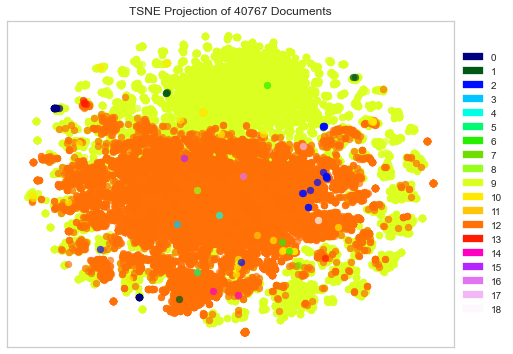

In [21]:
model, labels = mbkmeans_clusters(X, text_df['weight'].to_list(), k_range=19)
df_clusters = pd.DataFrame({
    "text": text_df['text'],
    "cluster": labels
})
tsne_viz(X, labels)

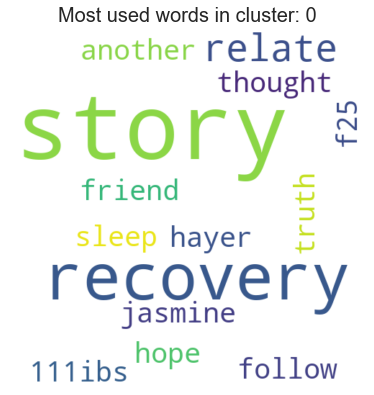

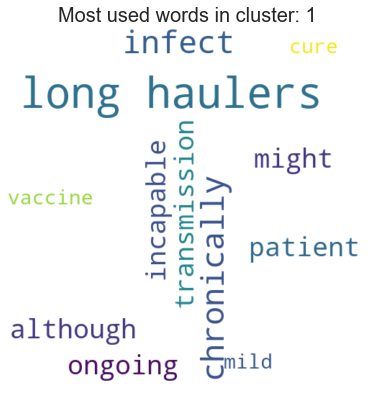

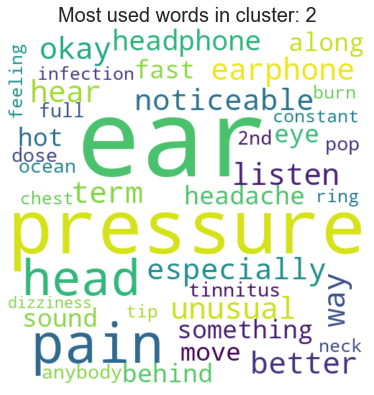

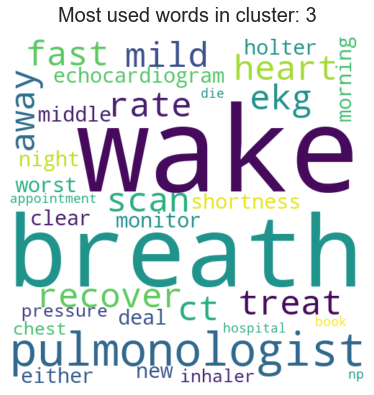

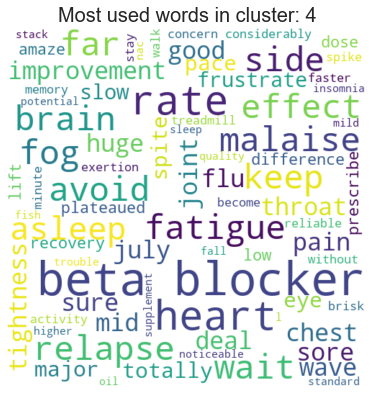

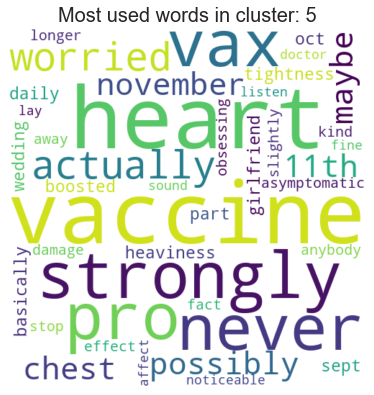

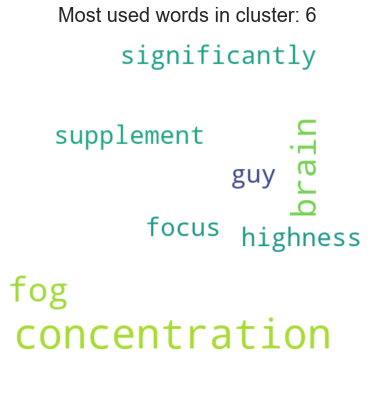

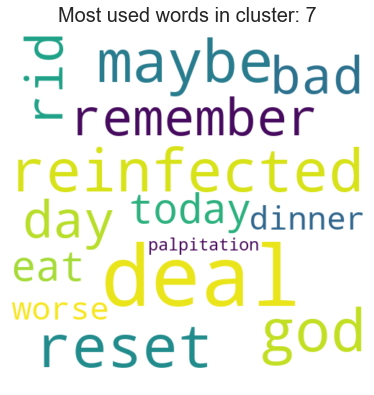

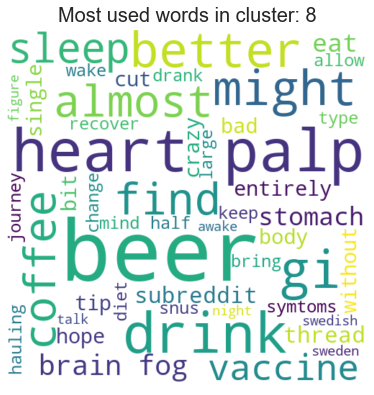

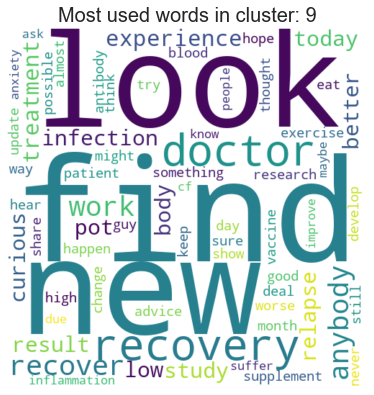

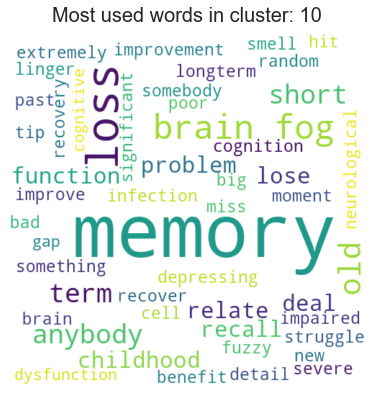

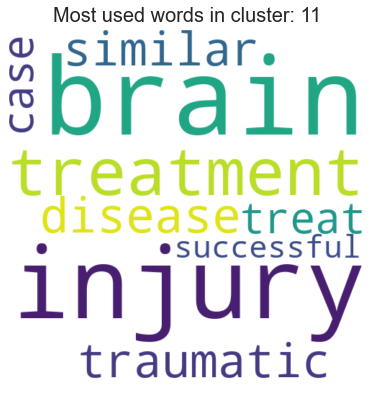

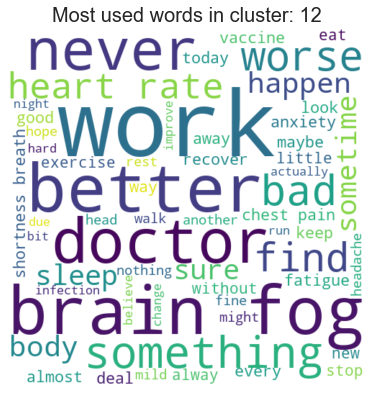

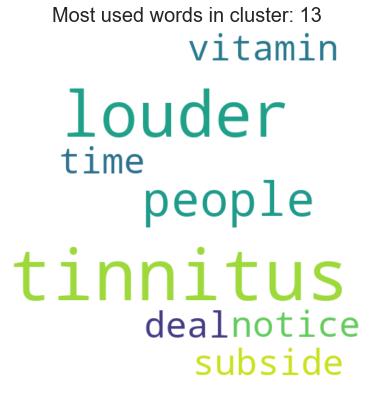

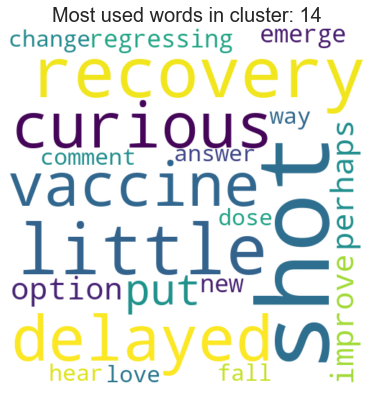

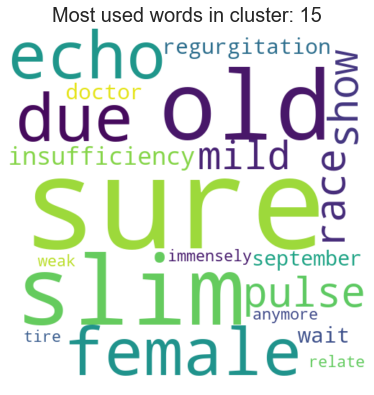

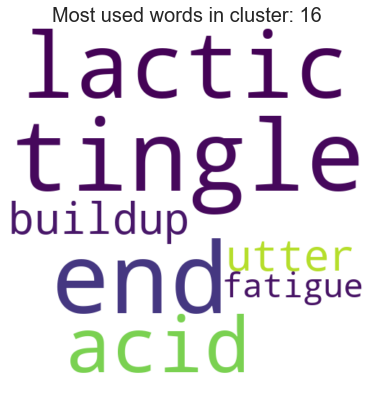

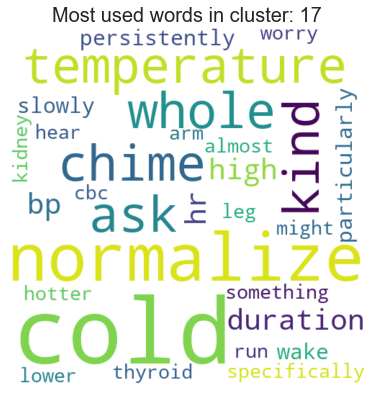

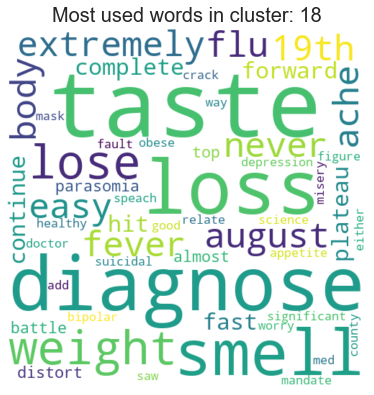

In [25]:
for i in range(0,19):
    create_wordcloud(df_clusters[df_clusters['cluster'] == i]['text'].to_list(), title="Most used words in cluster: " + str(i))

#### Trying a better number of clusters (elbow method not efficient)

Silhouette score:
0.011440680652955866


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

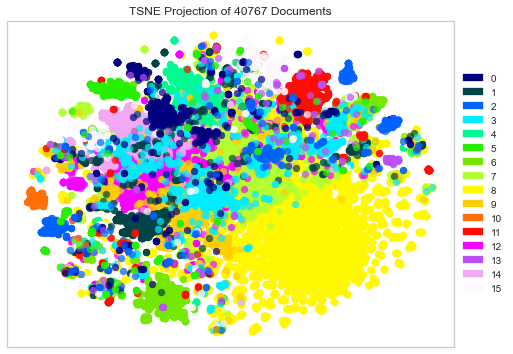

In [27]:
model, labels = mbkmeans_clusters(X, text_df['weight'].to_list(), 16)
df_clusters = pd.DataFrame({
    "text": text_df['text'],
    "cluster": labels
})
tsne_viz(X, labels)

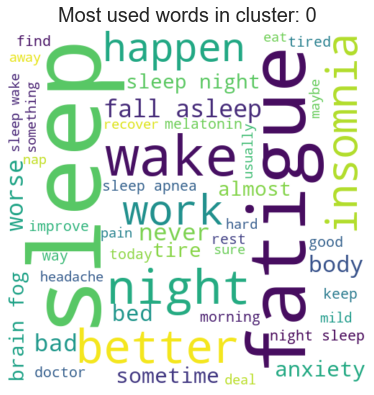

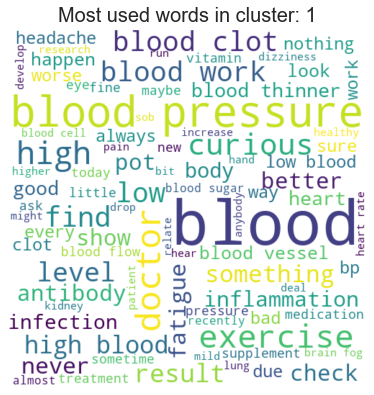

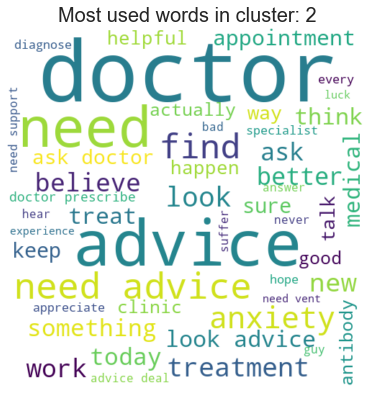

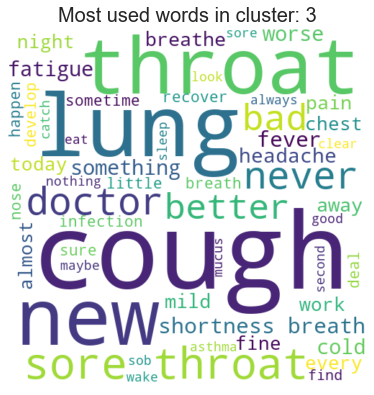

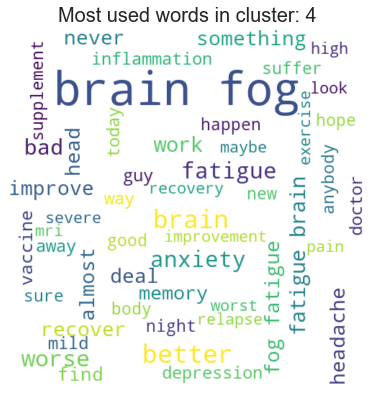

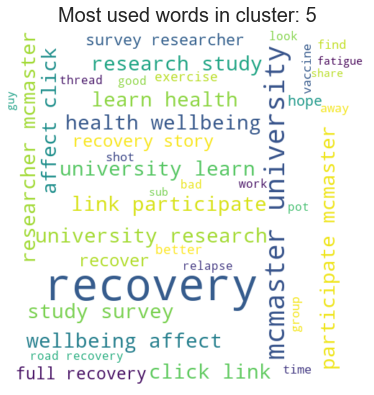

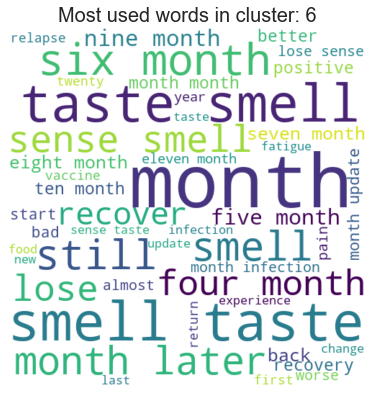

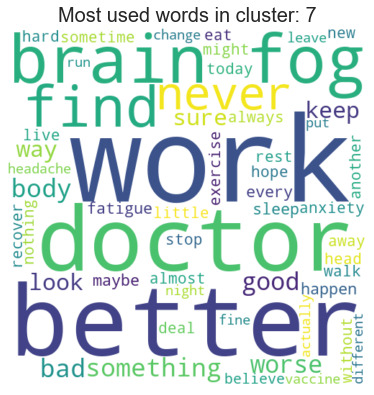

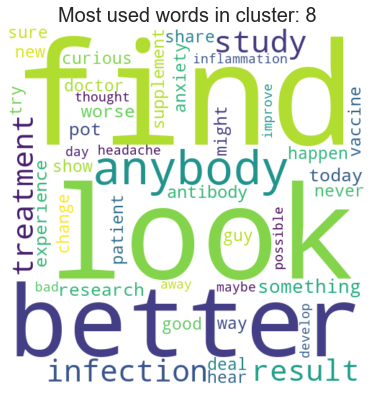

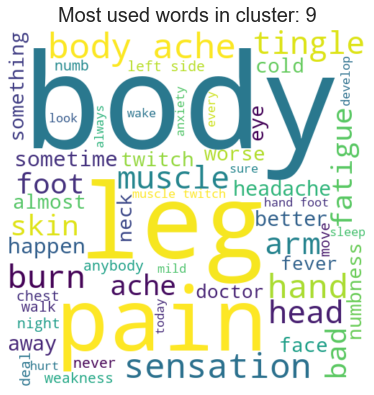

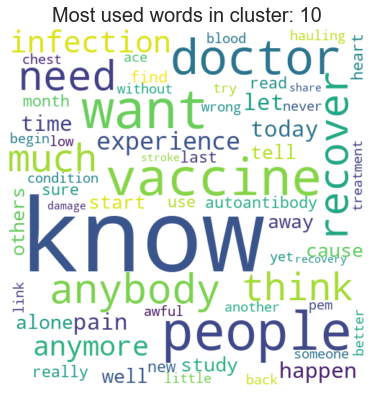

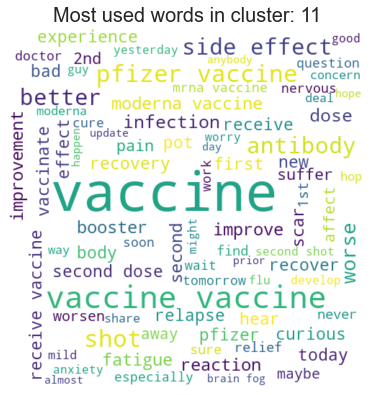

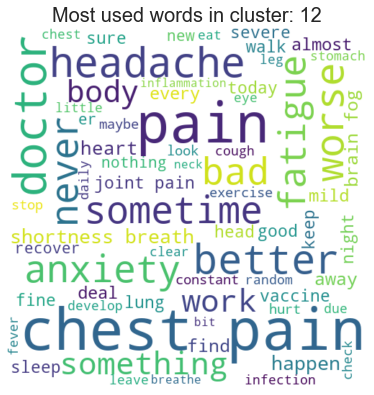

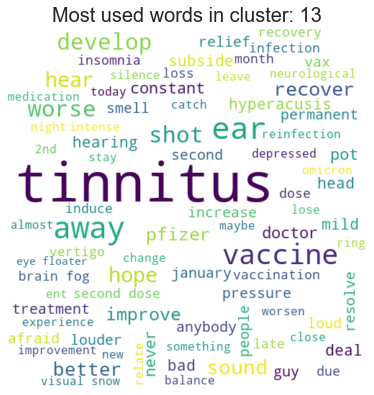

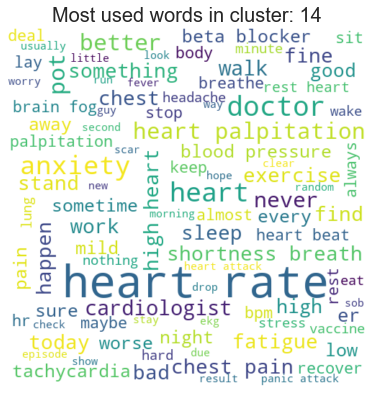

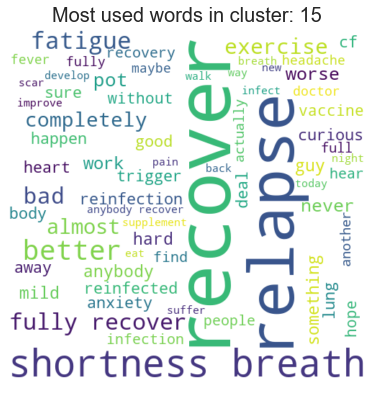

In [29]:
for i in range(0,16):
    create_wordcloud(df_clusters[df_clusters['cluster'] == i]['text'].to_list(), title="Most used words in cluster: " + str(i))

In [30]:
df_clusters[df_clusters['cluster'] == 12]['text'].to_list()

['suggest always recover better mean better worst impossible today rather main pot mild never fit low grade fever june july pot 120bpm stand sometimes sit least 100bpm often breathless walk sharp chest pain stand without heart crazy sit moment night sweat sharp pain kidney area bad smell urine occasional tingling lower body almost constant low grade fever ice pick headache search endless medical gaslighting solution quite depress october find good doctor care cardiac mri show nothing lung blood exam holter monitor show hr variation nothing conclusive doctor pot prescribed ivabradine kind beta blocker lower bpm enough stop dread rely medication forever natural improvement supplement result water salt exercise quit pass veery slowly better remain heart chest pain bad significantly better heart rate heart pound exception large meal random moment today forget pot almost every walk dog run bit quite sedentary relation pot stand quite often bpm standing 90 high standard hope doom better pot 